# Connect Colab to Google Drive

# Disabling Warnings

In [1]:
import warnings
import os
import sys
import yaml
import pickle
import argparse
from numbers import Number
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchvision
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from utils import *
from data.cmnist_data import *
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

/tmp/ipykernel_1208769/2766395790.py:18: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


## Creating CMNIST

In [2]:
# Load MNIST, make train/val splits, and shuffle train set examples
mnist = torchvision.datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:50000], mnist.targets[:50000])
mnist_val = (mnist.data[50000:], mnist.targets[50000:])

rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

# Build environment

envs = [
  make_environment(mnist_train[0][::2], mnist_train[1][::2], 0.2 , 0),
  make_environment(mnist_train[0][1::2], mnist_train[1][1::2], 0.1 , 1),
  make_environment(mnist_val[0], mnist_val[1], 0.9 , 2)
]

# Saving the envs list to a pickle file
with open('envs.pkl', 'wb') as f:
    pickle.dump(envs, f)

## Plotting some images

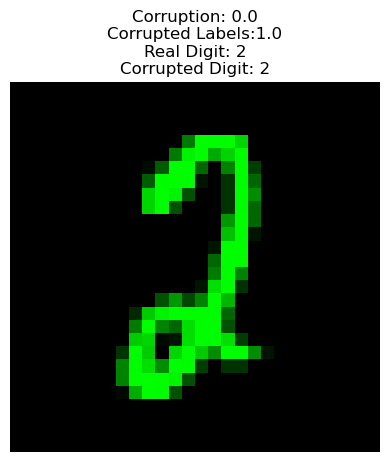

In [3]:
env_index = 1
num_plots = 2
num_plotted_images = 0
counter = 0
while(num_plotted_images < num_plots):
    img = envs[env_index]["images"][counter, :, :, :]
    real_digit = envs[env_index]["real_digit_labels"][counter]
    corrupted_digit = envs[env_index]["digit_labels"][counter]
    corruption = envs[env_index]["corrupted_mask"][counter]
    corrupted_labels = envs[env_index]["corrupted_labels"][counter]

    counter += 1

    if corruption.item()==1:
        continue
    if corrupted_digit <5 :
      plot_image(img, real_digit, corrupted_digit, corruption, corrupted_labels)
    num_plotted_images += 1

## Training

In [4]:
cee_training_yaml_file = "./cee_training.yaml"

In [5]:
# Read config file
with open(cee_training_yaml_file, 'r') as f:
  config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2namespace(config)

# Set device
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Make nescessary directories
make_dirs(config)

# Set radnom seed
if config.random_seed:
  np.random.seed(config.seed)
  torch.manual_seed(config.seed)

# Train the CEE Model
model, optimizer = train_cee(config)

# Save the last layer weigths
last_layer_weights = model.corruption_classifier[0].weight
torch.save(last_layer_weights, os.path.join(config.reports_path, "last_layer_weights.pt"))

save_net(
    file_path=config.reports_path,
    file_name="cee_final.ckpt",
    model=model,
    optimizer=optimizer
)



Training @ Epoch 1: 100%|█| 1562/1562 [00:14<00:00, 111.47it/s, acc1=0.777, loss
Training @ Epoch 2: 100%|█| 1562/1562 [00:14<00:00, 111.27it/s, acc1=0.810, loss


## plot_results

In [8]:
checkpoint_path = "./reports/cmnist/cee_2.ckpt"
cee = get_cee_model(config, 1, 1 , 1)
cee, _ = load_net(checkpoint_path, cee)

In [9]:
weights = cee.corruption_classifier[0].weight[0, :10]
normalized_weights = weights.abs() / weights.norm()
normalized_weights.sort()

torch.return_types.sort(
values=tensor([0.0058, 0.0079, 0.0093, 0.0125, 0.0137, 0.0211, 0.0228, 0.0383, 0.0423,
        0.9976], device='cuda:0', dtype=torch.float64, grad_fn=<SortBackward0>),
indices=tensor([9, 6, 8, 0, 3, 7, 1, 5, 4, 2], device='cuda:0'))

In [10]:
latent_selector = (normalized_weights > 0.6) #& (normalized_weights > 0.2)
latent_selector = latent_selector.tolist()
# image
env1_image = envs[0]["images"]
env2_image = envs[1]["images"]
env3_image = envs[2]["images"]

# labels
env1_label = envs[0]["corrupted_labels"].detach().cpu().numpy()
env2_label = envs[1]["corrupted_labels"].detach().cpu().numpy()
env3_label = envs[2]["corrupted_labels"].detach().cpu().numpy()

# Real Labels
env1_real_label = (envs[0]["real_digit_labels"] < 5).detach().cpu().numpy()
env2_real_label = (envs[1]["real_digit_labels"] < 5).detach().cpu().numpy()
env3_real_label = (envs[2]["real_digit_labels"] < 5).detach().cpu().numpy()

# Representation
env1_rep = cee.data_encoder(env1_image.to(torch.float64).to(config.device))[: , :10][:,latent_selector].detach().cpu().numpy()
env2_rep = cee.data_encoder(env2_image.to(torch.float64).to(config.device))[: , :10][:,latent_selector].detach().cpu().numpy()
env3_rep = cee.data_encoder(env3_image.to(torch.float64).to(config.device))[: , :10][:,latent_selector].detach().cpu().numpy()

# X
X_train = np.concatenate([env1_rep, env2_rep], axis=0)
X_test = env3_rep

# Y
Y_train = np.concatenate([env1_label, env2_label], axis=0)
Y_test = env3_label

# Y_real
Y_real_train = np.concatenate([env1_real_label, env2_real_label], axis=0)
Y_real_test = env3_real_label

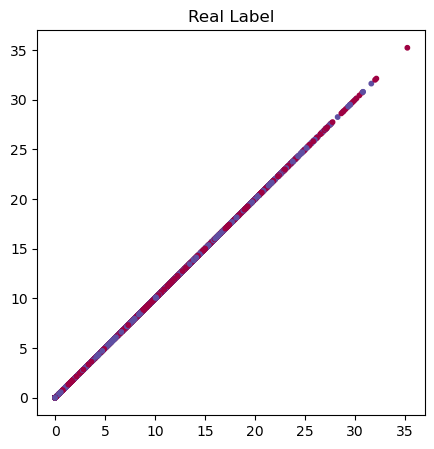

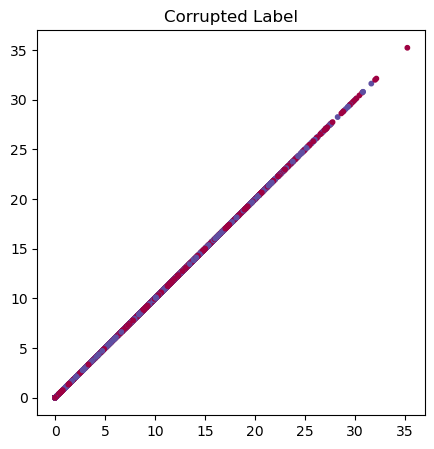

In [14]:
# Trai
plt.figure(figsize=(5, 5))
plt.scatter(X_train[:5000, 0], X_train[:5000, 0], s=10, c=Y_real_train[:5000], cmap="Spectral")
plt.title("Real Label")
plt.show()
plt.figure(figsize=(5, 5))
plt.scatter(X_train[:5000, 0], X_train[:5000, 0], s=10, c=Y_train[:5000], cmap="Spectral")
plt.title("Corrupted Label")
plt.show()

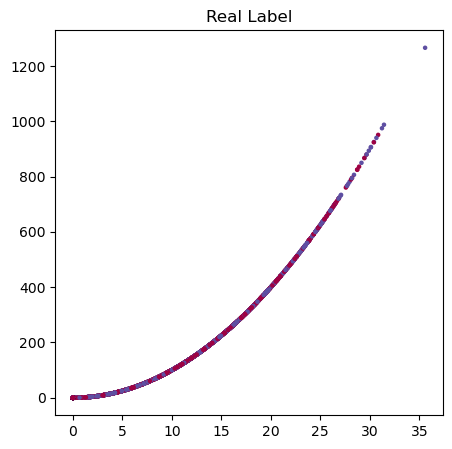

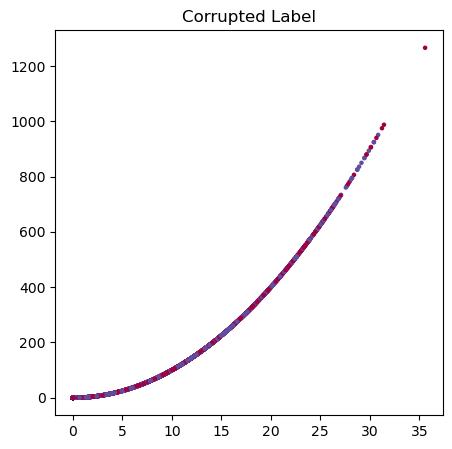

In [15]:
# Test
plt.figure(figsize=(5, 5))
plt.scatter(X_test[:, 0], X_test[:, 0]**2, s=5, c=Y_real_test, cmap='Spectral')
plt.title("Real Label")
plt.show()
plt.figure(figsize=(5, 5))
plt.scatter(X_test[:, 0], X_test[:, 0]**2, s=5, c=Y_test, cmap='Spectral')
plt.title("Corrupted Label")
plt.show()

In [16]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, Y_train)
pred = clf.predict(X_train)
print(f"percentage of digits less than 5 is : {pred.sum()/pred.shape[0]} ")
print("*" *2)
print("train_score , test_score are : "  ,clf.score(X_train, Y_train), 
      "  and  " , clf.score(X_test, Y_test)) 

percentage of digits less than 5 is : 0.63444 
**
train_score , test_score are :  0.5073   and   0.4912
